In [1]:
import os
os.chdir('../medhok')

SAMPLE_RATE = 16000
FRAME_SIZE = 0.025
FRAME_SIZE_SAMPLE = int(FRAME_SIZE * SAMPLE_RATE)
FRAME_STRIDE = 0.01
FRAME_STRIDE_SAMPLE = int(SAMPLE_RATE * FRAME_STRIDE)

def __trim_silence(wave, feature=None):
    if feature is not None:
        frame_length = FRAME_SIZE_SAMPLE
        hop_length = FRAME_STRIDE_SAMPLE
    else:
        frame_length = 1
        hop_length = 1
    _rms = librosa.feature.rms(wave, hop_length=hop_length, frame_length=frame_length)
    _threshold = np.mean(_rms) / 2 * 1.04   # formula from Shon et al. (2018)
    _mask = np.nonzero(_rms > _threshold)[1]
    if feature is not None:
        return wave[:, _mask]
    return wave[_mask]

In [2]:
from scipy.signal import butter, lfilter, filtfilt
import numpy as np

F_MAX = 4000
F_MIN = 200
POLYNOMIAL_ORDER = 6

def butter_lowpass(cutoff=F_MAX, fs=SAMPLE_RATE, order=POLYNOMIAL_ORDER):
    """Creates a butter low-pass.

    Args:
        cutoff (int): Cutoff frequency. Defaults to c.F_MAX
        fs (int): Sample rate. Defaults to c.SAMPLE_RATE
        order (_type_, optional): _description_. Defaults to c.POLYNOMIAL_ORDER.
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(wav, cutoff=F_MAX, fs=SAMPLE_RATE, order=POLYNOMIAL_ORDER):
    """Filters a wave data with a butter low-pass filter.

    Args:
        wav (_type_): Wave data wished to be processed with the low-pass filter.
        cutoff (_type_, optional): Frequency cutoff. Defaults to c.F_MAX.
        fs (_type_, optional): Sample rate. Defaults to c.SAMPLE_RATE.
        order (_type_, optional): Polynomial order. Defaults to c.POLYNOMIAL_ORDER.

    Returns:
        _type_: _description_
    """
    b, a = butter_lowpass(cutoff, fs, order)
    y = lfilter(b, a, wav)
    return y


def butter_highpass(cutoff=F_MIN, fs=SAMPLE_RATE, order=POLYNOMIAL_ORDER):
    """Creates a butter high-pass.

    Args:
        cutoff (_type_, optional): Frequency cutoff. Defaults to c.F_MIN.
        fs (_type_, optional): Sample rate. Defaults to c.SAMPLE_RATE.
        order (_type_, optional): Polynomial order. Defaults to c.POLYNOMIAL_ORDER.

    Returns:
        _type_: _description_
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a


def butter_highpass_filter(wav, cutoff=F_MIN, fs=SAMPLE_RATE, order=POLYNOMIAL_ORDER) -> np.ndarray:
    """Filters a wave data with a butter high pass filter.

    Args:
        wav (_type_): Wave data wished to be processed with the high-pass filter
        cutoff (_type_, optional): Frequency cutoff for the high-pass filter. Defaults to c.F_MIN.
        fs (_type_, optional): Sample rate. Defaults to c.SAMPLE_RATE.
        order (_type_, optional): Polynomial order. Defaults to c.POLYNOMIAL_ORDER.

    Returns:
        numpy.ndarray: The filtered wave data.
    """
    b, a = butter_highpass(cutoff, fs, order)
    y = filtfilt(b, a, wav)
    return y

def __filter_frequency(wav) -> np.ndarray:
        """Filter the wave frequency to only include frequencies audible to humans.

        Args:
            wav (numpy.ndarray): wave file

        Return:
            numpy.ndarray: filtered wave file
        """
        # Low-pass filter
        wav = filter.butter_lowpass_filter(wav, cutoff=F_MAX, fs=SAMPLE_RATE, order=POLYNOMIAL_ORDER)
        wav = filter.butter_highpass_filter(wav, cutoff=F_MIN, fs=SAMPLE_RATE, order=POLYNOMIAL_ORDER)
        return wav

In [3]:
import librosa
import numpy as np
%time _ = librosa.load('../data/audio/Ngadas/Marsam.wav', sr=SAMPLE_RATE, mono=True, res_type='soxr_vhq')[0]
_.shape

CPU times: user 2.66 s, sys: 240 ms, total: 2.89 s
Wall time: 2.9 s


(55479889,)

In [4]:
%time _ = np.append(_[0], _[1:] - 0.97 * _[:-1])
_.shape

CPU times: user 92 ms, sys: 67.9 ms, total: 160 ms
Wall time: 158 ms


(55479889,)

In [5]:
%time _ = __trim_silence(_, feature=None)
_.shape

CPU times: user 572 ms, sys: 176 ms, total: 748 ms
Wall time: 747 ms


(29722028,)

In [6]:
from numba import jit

USE_BOTH_NORMALISATION = True

def mel_spectrogram(wav):
    return librosa.feature.melspectrogram(
        wav, sr=SAMPLE_RATE, n_fft=FRAME_SIZE_SAMPLE,
        hop_length=FRAME_STRIDE_SAMPLE
)

@jit(nopython=True, fastmath=True)
def CMVN(
    feats: np.ndarray,
    mean_var=USE_BOTH_NORMALISATION
) -> np.ndarray:
    """
    Normalises features.
    :param feats: features to normalise
    :param mean_var: whether to normalise with respect to the mean and variance
    :return: normalised features
    # """
    # feats_new = feats.copy()
    for i in range(feats.shape[1]):
        feats[:, i] = feats[:, i] - np.mean(feats[:, i])
        if mean_var:
            feats[:, i] /= np.std(feats[:, i])

    return feats

# Whole file
_feature = mel_spectrogram(_)
_feature = CMVN(_feature)
np.save('../data/test/Marsam', _feature)

In [19]:
from pympler.asizeof import asizeof

f'{asizeof(_feature) / 1e6:.2f} MB'

'95.11 MB'

In [7]:
_feature.shape

(128, 185763)

In [12]:
SPLIT_SECOND = 5
SEGMENT_LENGTH = SAMPLE_RATE * SPLIT_SECOND
SEGMENT_STRIDE = SEGMENT_LENGTH // 2

def __split_segments(wav) -> np.ndarray:
        """Splits a wav file into several segments of decided seconds.

        Args:
            wav (_type_): input wav to be split

        Returns:
            np.ndarray: split segments
        """
        segments = []
        l_p = 0
        r_p = SEGMENT_LENGTH
        while l_p < wav.shape[0]:
            temp = wav[l_p:r_p]
            while temp.shape[0] < SEGMENT_LENGTH:
                temp = np.append(temp, [0] * (SEGMENT_LENGTH - temp.shape[0]))
            segments.append(temp)
            l_p += SEGMENT_STRIDE
            r_p += SEGMENT_STRIDE
        return np.array(segments, dtype=np.float32)

# Segmented
segments = __split_segments(_)
features = []
for iteration in range(segments.shape[0]):
    segment = segments[iteration]
    feature = mel_spectrogram(segment)
    feature = CMVN(feature)
    features.append(feature)
features = np.array(features)

In [13]:
features.shape

(744, 128, 501)

In [20]:
f'{asizeof(features) / 1e6:.2f} MB'

'190.85 MB'

In [14]:
np.save('../data/test/Marsam_segmented', features)

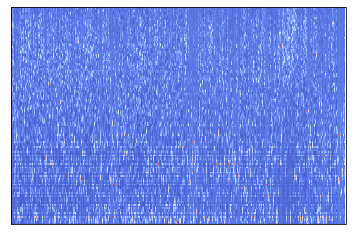

In [9]:
from librosa import display

display.specshow(_feature)

In [1]:
from pathlib import Path

_path = Path('../data/test/Marsam_segmented.npy')
_path

PosixPath('../data/test/Marsam_segmented.npy')

In [11]:
_path.parent.name

'test'